In [ ]:
!pip install surprise

     |████████████████████████████████| 6.5MB 71kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1670740 sha256=1527ca260a6271ad2fcd550a52a1a68c238258d279b7c05aeb10437357464132
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [ ]:
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(100836, 3)

In [ ]:
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)


In [ ]:
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.880456,3.998835,0.282019
NMF,0.933666,4.824095,0.215566
KNNBasic,0.958345,0.093289,2.265997
NormalPredictor,1.424985,0.103326,0.317489


In [ ]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

0.8674667831784787
{'n_factors': 40, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8654


0.8653693635064824

In [ ]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [ ]:
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,232,55232,3.5,2.897275,{'was_impossible': False},666,5,0.602725
1,239,6365,5.0,3.832991,{'was_impossible': False},197,71,1.167009
2,387,48774,4.5,3.500470,{'was_impossible': False},792,47,0.999530
3,156,4973,4.0,4.114419,{'was_impossible': False},306,91,0.114419
4,586,858,3.0,4.993646,{'was_impossible': False},159,143,1.993646


In [ ]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2703,43,262,5.0,5.000000,{'was_impossible': False},87,14,0.000000
17971,171,1201,5.0,5.000000,{'was_impossible': False},62,47,0.000000
1934,515,318,5.0,5.000000,{'was_impossible': False},21,231,0.000000
3644,53,4019,5.0,5.000000,{'was_impossible': False},15,21,0.000000
20645,30,318,5.0,5.000000,{'was_impossible': False},20,231,0.000000
6195,43,588,5.0,5.000000,{'was_impossible': False},87,139,0.000000
2162,452,1197,5.0,5.000000,{'was_impossible': False},149,104,0.000000
4739,452,858,5.0,5.000000,{'was_impossible': False},149,143,0.000000
16267,219,3552,3.5,3.499956,{'was_impossible': False},402,43,0.000044
15728,599,256,2.0,1.999951,{'was_impossible': False},1840,23,0.000049


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4934,393,53996,0.5,4.081672,{'was_impossible': False},97,28,3.581672
6245,543,59900,0.5,4.096460,{'was_impossible': False},55,10,3.596460
4506,393,5445,0.5,4.147291,{'was_impossible': False},97,83,3.647291
18280,393,27611,0.5,4.233238,{'was_impossible': False},97,14,3.733238
24215,527,527,1.0,4.804809,{'was_impossible': False},124,165,3.804809
12095,594,5909,0.5,4.329467,{'was_impossible': False},166,3,3.829467
20936,573,3996,0.5,4.409931,{'was_impossible': False},221,86,3.909931
9226,393,778,0.5,4.417681,{'was_impossible': False},97,75,3.917681
4834,543,213,0.5,5.000000,{'was_impossible': False},55,3,4.500000
7359,543,89904,0.5,5.000000,{'was_impossible': False},55,6,4.500000


In [ ]:
df.loc[df['itemID'] == 7359]['rating'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: rating, dtype: float64

In [ ]:
final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,25209,0,0,0,1.000000,1.000000,1.000000
1,0.5,25209,0,0,0,1.000000,1.000000,1.000000
2,1.0,24861,348,0,0,0.986195,1.000000,0.993050
3,1.5,24187,1003,9,10,0.960183,0.999587,0.979489
4,2.0,23655,1359,101,94,0.945670,0.996042,0.970203
5,2.5,21299,2707,694,509,0.887237,0.976660,0.929803
6,3.0,18155,2445,2396,2213,0.881311,0.891349,0.886302
7,3.5,10512,2641,7157,4899,0.799209,0.682110,0.736031
8,4.0,3938,784,12268,8219,0.833969,0.323929,0.466615
9,4.5,428,183,19622,4976,0.700491,0.079201,0.142311


In [ ]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    
    
###

In [ ]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

###

[{'K': 2, 'Precision': 0.9459016393442623, 'Recall': 0.17063562625089712},
 {'K': 3, 'Precision': 0.9448087431693993, 'Recall': 0.25047232920949286},
 {'K': 4, 'Precision': 0.9415300546448084, 'Recall': 0.3201601170431681},
 {'K': 5, 'Precision': 0.9374316939890719, 'Recall': 0.38504217671660473},
 {'K': 6, 'Precision': 0.9356284153005453, 'Recall': 0.43857402997506545},
 {'K': 7, 'Precision': 0.9313739266198263, 'Recall': 0.48330665699760783},
 {'K': 8, 'Precision': 0.9291198282591718, 'Recall': 0.5239293543576625},
 {'K': 9, 'Precision': 0.9262509758001567, 'Recall': 0.556638972614597},
 {'K': 10, 'Precision': 0.9239194639604461, 'Recall': 0.5861476728801244}]

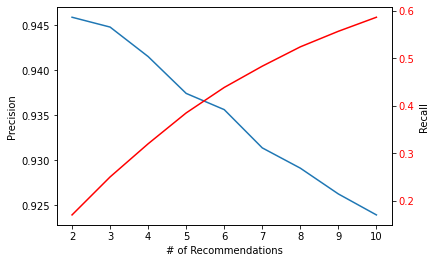

In [ ]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
    ###

In [ ]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [ ]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [ ]:
all_pred = get_all_predictions(predictions)

In [ ]:
n = 4

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]

In [ ]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [ ]:
user_id=67
results = get_predictions(user_id)
results

0    (3451, 4.444474994059728)
1    (1104, 4.421293164265549)
2    (2360, 4.403655550938905)
3    (3030, 4.400286853845291)
Name: 67, dtype: object

In [ ]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids

[3451, 1104, 2360, 3030]

In [ ]:
movies = pd.read_csv('movies.csv')
movies.head()
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies

,movieId,title,genres
841,1104,"Streetcar Named Desire, A (1951)",Drama
1762,2360,"Celebration, The (Festen) (1998)",Drama
2283,3030,Yojimbo (1961),Action|Adventure
2582,3451,Guess Who's Coming to Dinner (1967),Drama


In [ ]:
ratings = pd.read_csv('ratings.csv')


ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.head()

,itemID,userID,rating
0,1,1,4.0
1,3,1,4.0
2,6,1,4.0
3,47,1,5.0
4,50,1,5.0


In [ ]:
temp = df[df['userID'] == 67].sort_values("rating", ascending = False)
temp.head()

,itemID,userID,rating
10324,293,67,5.0
10352,8604,67,5.0
10332,1527,67,5.0
10354,27193,67,5.0
10343,4886,67,4.5


In [ ]:
temp.shape

(36, 3)

In [ ]:
history_movie_ids = temp['itemID']
user_history = movies[movies['movieId'].isin(history_movie_ids)]

In [ ]:
user_history[:n]

,movieId,title,genres
254,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War


In [ ]:
recommended_movies

,movieId,title,genres
841,1104,"Streetcar Named Desire, A (1951)",Drama
1762,2360,"Celebration, The (Festen) (1998)",Drama
2283,3030,Yojimbo (1961),Action|Adventure
2582,3451,Guess Who's Coming to Dinner (1967),Drama
